In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
torch.manual_seed(0)

In [2]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [3]:
def get_generator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True),
    )

In [4]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, im_dim=28*28, hidden_dim=128):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            get_generator_block(z_dim, hidden_dim),
            get_generator_block(hidden_dim, hidden_dim * 2),
            get_generator_block(hidden_dim * 2, hidden_dim * 4),
            get_generator_block(hidden_dim * 4, hidden_dim * 8),
            nn.Linear(hidden_dim * 8, im_dim),
            nn.Sigmoid()
        )
    def forward(self, noise):
        return self.gen(noise)
    def get_gen(self):
        return self.gen

In [5]:
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples,z_dim,device=device)

In [6]:
def get_discriminator_block(input_dim, output_dim):
    return nn.Sequential(
         nn.Linear(input_dim, output_dim),
         nn.LeakyReLU(0.2, inplace=True)
    )

In [7]:
class Discriminator(nn.Module):
    def __init__(self, im_dim=28*28, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim * 4),
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim),
            nn.Linear(hidden_dim, 1)
        )
    def forward(self, image):
        return self.disc(image)
    
    def get_disc(self):
        return self.disc

In [8]:
criterion = nn.BCEWithLogitsLoss()
n_epochs = 100
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.00001
device = 'cuda'
dataloader = DataLoader(
    MNIST('.', download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)

In [9]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [10]:
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
    fake_noise = get_noise(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake.detach())
    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
    disc_real_pred = disc(real)
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
    disc_loss = (disc_fake_loss + disc_real_loss) / 2
    return disc_loss

In [11]:
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    fake_noise = get_noise(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake)
    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
    return gen_loss

In [12]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
generator_losses = []
discriminator_losses = []
gen_loss = False
error = False
for epoch in range(n_epochs):
    print('epoch: ',epoch+1)
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.view(cur_batch_size, -1).to(device)
        disc_opt.zero_grad()
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)
        discriminator_losses += [disc_loss.item()]
        disc_loss.backward(retain_graph=True)
        disc_opt.step()
        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
        generator_losses += [gen_loss.item()]
        gen_loss.backward()
        gen_opt.step()

torch.save(gen.state_dict(),'weights_gan_gen')  
torch.save(gen.state_dict(),'weights_gan_disc')      

epoch:  1


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  2


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  3


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  4


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  5


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  6


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  7


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  8


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  9


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  10


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  11


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  12


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  13


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  14


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  15


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  16


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  17


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  18


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  19


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  20


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  21


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  22


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  23


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  24


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  25


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  26


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  27


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  28


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  29


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  30


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  31


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  32


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  33


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  34


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  35


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  36


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  37


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  38


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  39


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  40


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  41


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  42


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  43


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  44


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  45


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  46


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  47


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  48


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  49


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  50


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  51


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  52


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  53


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  54


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  55


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  56


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  57


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  58


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  59


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  60


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  61


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  62


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  63


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  64


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  65


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  66


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  67


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  68


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  69


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  70


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  71


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  72


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  73


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  74


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  75


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  76


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  77


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  78


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  79


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  80


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  81


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  82


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  83


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  84


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  85


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  86


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  87


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  88


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  89


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  90


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  91


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  92


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  93


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  94


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  95


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  96


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  97


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  98


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  99


  0%|          | 0/469 [00:00<?, ?it/s]

epoch:  100


  0%|          | 0/469 [00:00<?, ?it/s]

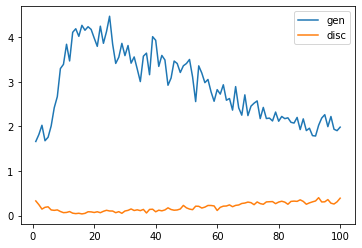

In [16]:
import numpy as np
gen_loss_ep = []
disc_loss_ep = []
for i in range(46900):
  if (i%468 == 0 and i!=0):
    gen_loss_ep.append(generator_losses[i])
    disc_loss_ep.append(discriminator_losses[i])
plt.plot([t+1 for t in range(100)],gen_loss_ep,label="gen")
plt.plot(range(1,101),disc_loss_ep,label="disc")
plt.legend()
plt.show()

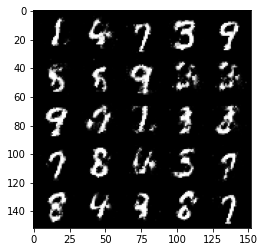

In [15]:
noise_25 = get_noise(25,64,device=device)
imgs_25 = gen(noise_25)
show_tensor_images(imgs_25)